In [1]:
# Links for contours
# https://github.com/JuliaGeometry/Contour.jl/blob/master/src/Contour.jl
# This code is from:
# https://github.com/JuliaImages/juliaimages.github.io/blob/source/docs/examples/contours/contour_detection.jl

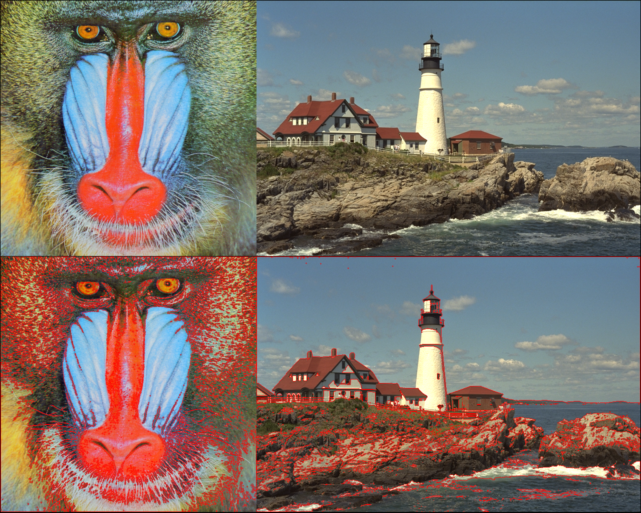

  likely near /Users/adrita/.julia/packages/IJulia/F1GUo/src/kernel.jl:52
  likely near /Users/adrita/.julia/packages/IJulia/F1GUo/src/kernel.jl:52
  likely near /Users/adrita/.julia/packages/IJulia/F1GUo/src/kernel.jl:52
  likely near /Users/adrita/.julia/packages/IJulia/F1GUo/src/kernel.jl:52
  likely near /Users/adrita/.julia/packages/IJulia/F1GUo/src/kernel.jl:52
  likely near /Users/adrita/.julia/packages/IJulia/F1GUo/src/kernel.jl:52


In [2]:
# ---
# cover: assets/contour_detection.png
# title: Contour Detection and Drawing
# ---

# This demonstration shows how to detect contours on binary images
# The algorithm used is ["Topological Structural Analysis of Digitized Binary Images
# by Border Following"](https://www.sciencedirect.com/science/article/pii/0734189X85900167) by Suzuki and Abe (Same as OpenCV).#

# Points are represented using CartesianIndex. Contours are represented as a vector of Points.
# Direction is a single number between 1 to 8. Steps inside functions are marked as they are in the original paper

using Images, TestImages, FileIO

##              N          NE      E       SE      S       SW        W      NW
## direction between two pixels

## rotate direction clocwise
function clockwise(dir)
    return (dir)%8 + 1
end

## rotate direction counterclocwise
function counterclockwise(dir)
    return (dir+6)%8 + 1
end

## move from current pixel to next in given direction
function move(pixel, image, dir, dir_delta)
    newp = pixel + dir_delta[dir]
    height, width = size(image)
    if (0 < newp[1] <= height) &&  (0 < newp[2] <= width)
        if image[newp]!=0
            return newp
        end
    end
    return CartesianIndex(0, 0)
end

## finds direction between two given pixels
function from_to(from, to, dir_delta)
    delta = to-from
    return findall(x->x == delta, dir_delta)[1]
end



function detect_move(image, p0, p2, nbd, border, done, dir_delta)
    dir = from_to(p0, p2, dir_delta)
    moved = clockwise(dir)
    p1 = CartesianIndex(0, 0)
    while moved != dir ## 3.1
        newp = move(p0, image, moved, dir_delta)
        if newp[1]!=0
            p1 = newp
            break
        end
        moved = clockwise(moved)
    end

    if p1 == CartesianIndex(0, 0)
        return
    end

    p2 = p1 ## 3.2
    p3 = p0 ## 3.2
    done .= false
    while true
        dir = from_to(p3, p2, dir_delta)
        moved = counterclockwise(dir)
        p4 = CartesianIndex(0, 0)
        done .= false
        while true ## 3.3
            p4 = move(p3, image, moved, dir_delta)
            if p4[1] != 0
                break
            end
            done[moved] = true
            moved = counterclockwise(moved)
        end
        push!(border, p3) ## 3.4
        if p3[1] == size(image, 1) || done[3]
            image[p3] = -nbd
        elseif image[p3] == 1
            image[p3] = nbd
        end

        if (p4 == p0 && p3 == p1) ## 3.5
            break
        end
        p2 = p3
        p3 = p4
    end
end


function find_contours(image)
    nbd = 1
    lnbd = 1
    image = convert(Array{Float64}, image)
    contour_list =  Vector{typeof(CartesianIndex[])}()
    done = [false, false, false, false, false, false, false, false]

    ## Clockwise Moore neighborhood.
    dir_delta = [CartesianIndex(-1, 0) , CartesianIndex(-1, 1), CartesianIndex(0, 1), CartesianIndex(1, 1), CartesianIndex(1, 0), CartesianIndex(1, -1), CartesianIndex(0, -1), CartesianIndex(-1,-1)]

    height, width = size(image)

    for i=1:height
        lnbd = 1
        for j=1:width
            fji = image[i, j]
            is_outer = (image[i, j] == 1 && (j == 1 || image[i, j-1] == 0)) ## 1 (a)
            is_hole = (image[i, j] >= 1 && (j == width || image[i, j+1] == 0))

            if is_outer || is_hole
                ## 2
                border = CartesianIndex[]

                from = CartesianIndex(i, j)

                if is_outer
                    nbd += 1
                    from -= CartesianIndex(0, 1)

                else
                    nbd += 1
                    if fji > 1
                        lnbd = fji
                    end
                    from += CartesianIndex(0, 1)
                end

                p0 = CartesianIndex(i,j)
                detect_move(image, p0, from, nbd, border, done, dir_delta) ## 3
                if isempty(border) ##TODO
                    push!(border, p0)
                    image[p0] = -nbd
                end
                push!(contour_list, border)
            end
            if fji != 0 && fji != 1
                lnbd = abs(fji)
            end

        end
    end

    return contour_list


end

## a contour is a vector of 2 int arrays
function draw_contour(image, color, contour)
    for ind in contour
        image[ind] = color
    end
end
function draw_contours(image, color, contours)
    for cnt in contours
        draw_contour(image, color, cnt)
    end
end

## load images
img1 = testimage("mandrill")
img2 = testimage("lighthouse")

## convert to grayscale
imgg1 = Gray.(img1)
imgg2 = Gray.(img2)

## threshold
imgg1 = imgg1 .> 0.45
imgg2 = imgg2 .> 0.45

## calling find_contours
cnts1 = find_contours(imgg1)
cnts2 = find_contours(imgg2)

img3 = copy(img1)
img4 = copy(img2)

## finally, draw the detected contours
draw_contours(img3, RGB(1,0,0), cnts1)
draw_contours(img4, RGB(1,0,0), cnts2)


vcat([img1 img2], [img3 img4])